<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Overfitting%20Model%20for%20Hybrid%20RF-LSTM%20for%2010%20class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid RF-LSTM for 10 class classifications based on UNSW-NB15 dataset ver.2.1**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_P2.2.csv") # update dataset
dataset.isnull().sum()

id                   0
dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
Class                0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   spkts              175341 non-null  int64  
 3   dpkts              175341 non-null  int64  
 4   sbytes             175341 non-null  int64  
 5   dbytes             175341 non-null  int64  
 6   rate               175341 non-null  float64
 7   sttl               175341 non-null  int64  
 8   dttl               175341 non-null  int64  
 9   sload              175341 non-null  float64
 10  dload              175341 non-null  float64
 11  sloss              175341 non-null  int64  
 12  dloss              175341 non-null  int64  
 13  sinpkt             175341 non-null  float64
 14  dinpkt             175341 non-null  float64
 15  sjit               175341 non-null  float64
 16  dj

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=10)  # update to 10 classes
X = dataset.drop(['Class'], axis=1)
X = X.values
print(X.shape)
print(y.shape)

(175341, 40)
(175341, 10)


**Data preprocessing**

In [5]:
# Data preprocessing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

**Hybrid RF-LSTM for 10 classes**

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, np.argmax(y_train, axis=1))

# Extract features from RF model
train_rf_features = rf_model.predict_proba(X_train)
test_rf_features = rf_model.predict_proba(X_test)

In [8]:
# Reshape train_rf_features to 3D array
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], train_rf_features.shape[1], 1))

# Train LSTM model with RF features as input
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(train_rf_features.shape[1], train_rf_features.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(10, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_model.fit(train_rf_features, y_train, epochs=15, batch_size=64, validation_data=(test_rf_features, y_test))

Epoch 1/15
7000/7000 [==============================] - 250s 35ms/step - loss: 0.0566 - accuracy: 0.9846 - val_loss: 1.4756 - val_accuracy: 0.8513
Epoch 2/15
7000/7000 [==============================] - 243s 35ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.5418 - val_accuracy: 0.8585
Epoch 3/15
7000/7000 [==============================] - 245s 35ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.5883 - val_accuracy: 0.8601
Epoch 4/15
7000/7000 [==============================] - 242s 35ms/step - loss: 9.5237e-04 - accuracy: 0.9998 - val_loss: 1.6785 - val_accuracy: 0.8638
Epoch 5/15
7000/7000 [==============================] - 240s 34ms/step - loss: 8.8381e-04 - accuracy: 0.9998 - val_loss: 1.8213 - val_accuracy: 0.8427
Epoch 6/15
7000/7000 [==============================] - 239s 34ms/step - loss: 6.6256e-04 - accuracy: 0.9998 - val_loss: 1.5708 - val_accuracy: 0.8489
Epoch 7/15
7000/7000 [==============================] - 240s 34ms/step - loss: 8.4263e-04 - accuracy: 0.99

3500/3500 [==============================] - 30s 8ms/step
Accuracy: 0.8598839285714286
Recall: 0.8598839285714286
Precision: 0.8599918015966361
F1-Score: 0.8592565013205118
Confusion Matrix:
 [[10915    29     1     2    47   272     0     3     5     3]
 [    3  9131   698   848   415    68     2    74     5    99]
 [    0   691  9147   554   420    36     1   244    29   103]
 [    0  1049   970  6309  2151   163    18   276    91   192]
 [    4   357   283  1557  8446   176    15   292    90    77]
 [   68   209   161   265   287  9948     1   101    99    35]
 [    0     9    13    36   123    10 10869     4     5     5]
 [    0   254   542   429   413    49     1  9301   104    36]
 [    0     0     0     1     2     8     1     3 11095     2]
 [    0     0     0     0     4     0     0     0     0 11146]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     11277
           1       0.78      0.80      0.79 

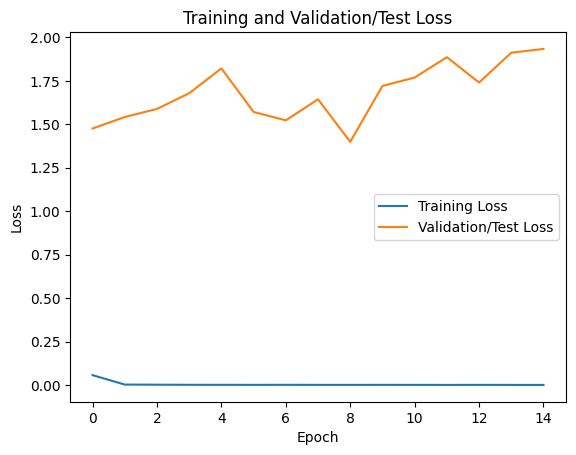

In [9]:
# Evaluate hybrid model on test set
test_rf_features_lstm = rf_model.predict_proba(X_test)
test_rf_features_lstm = np.reshape(test_rf_features_lstm, (test_rf_features_lstm.shape[0], 10, 1))  # Modify shape to (None, 4, 1)
test_lstm_features = lstm_model.predict(test_rf_features_lstm)

# Predict labels from hybrid model
test_rf_features_lstm = np.argmax(test_lstm_features, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), test_rf_features_lstm)
recall = recall_score(np.argmax(y_test, axis=1), test_rf_features_lstm, average='weighted')
precision = precision_score(np.argmax(y_test, axis=1), test_rf_features_lstm, average='weighted')
f1score = f1_score(np.argmax(y_test, axis=1), test_rf_features_lstm, average='weighted')
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), test_rf_features_lstm)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_rf_features_lstm)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

# Plot training loss and validation/test loss over each epoch of training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()